# Moveworks Take Home Assignment For DS Roles

## Applicant: Yu-Ting Shen

* Data: [ambient_temperature_system_failure.csv](https://github.com/numenta/NAB/blob/master/data/realKnownCause/ambient_temperature_system_failure.csv)

* Question 1: - **Explore**

Explain the shape and characteristic of the data. Use any visuals you see fit to explain the shape of the data. Anything interesting you observe? Any other insights you discovered? What other types of exploratory analysis would you like to do?


* Question 2: - **Feature Engineering**

What features would you like to build to extend the data set? Extend your data set with these new features you identified in the previous step. Explore your newly transformed data now. Anything interesting you observe?


* Question 3: - **Anomaly Detection**

Please pick either a statistical, clustering, or classification approach to detect anomaly (for the sake of time, no need to do more than one approach), and briefly discuss the rationale and pros/cons of different approaches.


* How will you present your findings?
---

## Step 1. Load dataset & data cleaning

The first step is loading the data into a data frame and checking the basic information of the data.

In [1]:
import pandas as pd
from IPython.display import display

# load data
df = pd.read_csv('ambient_temperature_system_failure.csv')

In [2]:
# show basic information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [3]:
# show the first 5 rows of the dataframe
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
# show statistical information of the dataframe
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


* This dataset contains 7267 rows with 2 columns. 
* The first column is timestamp but the type is **object**. Because the first column is timestamp format, I would like to convert the type into datetime.
* The data was taken **hourly**.
* The data value ranges from 57.45 to 86.22 with average value equals 71.24 and standard deviation equals 4.24

In [5]:
# convert the timestamp column into datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)

# show the basic information again to make sure the type is datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB


In [6]:
# Order the dataframe using the timestamp column 
df = df.sort_values(by='timestamp')

# df.head()

# show the minimum and maximum of the datetime range
print(f"minimum={df['timestamp'].min()}, maximum={df['timestamp'].max()}")

minimum=2013-07-04 00:00:00, maximum=2014-05-28 15:00:00


Since I have the minimum and maximum of the timestamp, I can calculate the data duration.

In [7]:
print(f"Data duration = {df['timestamp'].max() - df['timestamp'].min()}")

Data duration = 328 days 15:00:00


Because the data was taken hourly, let me convert the above duration into hours

In [8]:
print(f"Data duration (in hours)= {(df['timestamp'].max() - df['timestamp'].min()) / pd.Timedelta(1, 'h')} hours")

Data duration (in hours)= 7887.0 hours


If the data was taken hourly from 2013-07-04 00:00:00 to 2014-05-28 15:00:00, then there should be 7887 data points. However, we only have 7267 records in the data frame. This means that **there are some missing values**

In [9]:
print(f"Number of missing values = {7887 - 7267 + 1}")

Number of missing values = 621


Now let me identify the range with missing data and create a new data frame with missing values imputation.
* Create a new column call "lag" which is the timestamp from previous record.
* Calculate the time difference between timestamp and lag columns.
* If the time difference is greater than 1, then there are missing values between the specific row and it's previous row.

In [10]:
# use lag to get the timestamp of previous row and .
df['lag'] = df.timestamp.shift(1)

# calculate the time difference
# Because the results is in "X days hh:mm:ss" format, I would like to convert into hours, therefore, 
# I divide the results by 1 hour (i.e. pd.Timedelta(1, 'h'))
df['time_diff'] = (df['timestamp'] - df['lag']) / pd.Timedelta(1, 'h')


# Find the missing values
# If the time_diff > 1.0, then there are missing values.
df[df['time_diff']>1.0]

,timestamp,value,lag,time_diff
578,2013-07-28 03:00:00,72.782389,2013-07-28 01:00:00,2.0
580,2013-07-29 12:00:00,73.243443,2013-07-28 04:00:00,32.0
1276,2013-08-29 11:00:00,67.619708,2013-08-27 11:00:00,48.0
1550,2013-09-16 12:00:00,72.696440,2013-09-09 20:00:00,160.0
1815,2013-10-01 12:00:00,75.664288,2013-09-27 12:00:00,96.0
2064,2013-10-14 19:00:00,72.983034,2013-10-11 20:00:00,71.0
5385,2014-03-03 09:00:00,64.737526,2014-03-02 03:00:00,30.0
5739,2014-03-18 05:00:00,66.693992,2014-03-18 02:00:00,3.0
5883,2014-03-24 19:00:00,71.943363,2014-03-24 04:00:00,15.0
6114,2014-04-10 15:00:00,69.954680,2014-04-03 09:00:00,174.0


Create a new dataframe with missing value imputation.
* I will create a new dataframe with hourly data. The missing values are imputed using forward linear interpolation.
* Create new columns to save year, month, day, hours information

In [11]:
# create hourly time stamp
hourly = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='H')

# create new dataframe
df_imputed = pd.DataFrame({'timestamp': hourly})
df_imputed = pd.merge(df_imputed, df, on=['timestamp'], how='left')
print(f"Before imputation, there are {len(df_imputed[df_imputed['value'].isna()])} rows with missing values")

# use forward linear interpolation 
df_imputed['value'].interpolate(method="linear", inplace=True)
print(f"After imputation, there are {len(df_imputed[df_imputed['value'].isna()])} rows with missing values")

Before imputation, there are 621 rows with missing values
After imputation, there are 0 rows with missing values


In [12]:
# Create new columns to save year, month, day, hours
df_imputed['year'] = df_imputed['timestamp'].dt.year
df_imputed['month'] = df_imputed['timestamp'].dt.month
df_imputed['day'] = df_imputed['timestamp'].dt.day
df_imputed['hour'] = df_imputed['timestamp'].dt.hour

In [13]:
# Now I can drop the lag and time_diff columns from the imputed dataframe
df_imputed.drop(columns=['lag', 'time_diff'], inplace=True)
df_imputed.head()

,timestamp,value,year,month,day,hour
0,2013-07-04 00:00:00,69.880835,2013,7,4,0
1,2013-07-04 01:00:00,71.220227,2013,7,4,1
2,2013-07-04 02:00:00,70.877805,2013,7,4,2
3,2013-07-04 03:00:00,68.959400,2013,7,4,3
4,2013-07-04 04:00:00,69.283551,2013,7,4,4


## Step 2. Visualize data

Before plotting the distribution, I would like to set the timestamp column as index because the data is time series. After setting the index to timestamp column, I can plot the distribution using the matplotlib and seaborn.

In [14]:
# set timestamp as the index for the original dataframe
df = df.set_index('timestamp')

# set timestamp as the index for the imputed dataframe
df_imputed = df_imputed.set_index('timestamp')

Because the data was taken hourly, I would like to get the moving averages for daily, weekly and monthly.

In [15]:
df_imputed['MA_daily'] = df_imputed['value'].rolling(window=24).mean()
df_imputed['MA_weekly'] = df_imputed['value'].rolling(window=24*7).mean()
df_imputed['MA_monthly'] = df_imputed['value'].rolling(window=24*30).mean()

Because the data is time series, I usually make the following plots to visualize time series data
1. **time series line plot**: to see the data distribution w.r.t time
2. **histogram and density plots**: to see the data distribution
3. **box plot**: to see distribution of values by time interval.
4. **decomposition plot**: to see the trend, seasonality, and noise (residual)
5. **lag scatter plot**: to see the relation between y(t) and y(t+1)
6. **auto-correlation plot and partial auto-correlation plot**: to see the correlation betweey y(t) and y(t-1)

#### 1. time series line plot

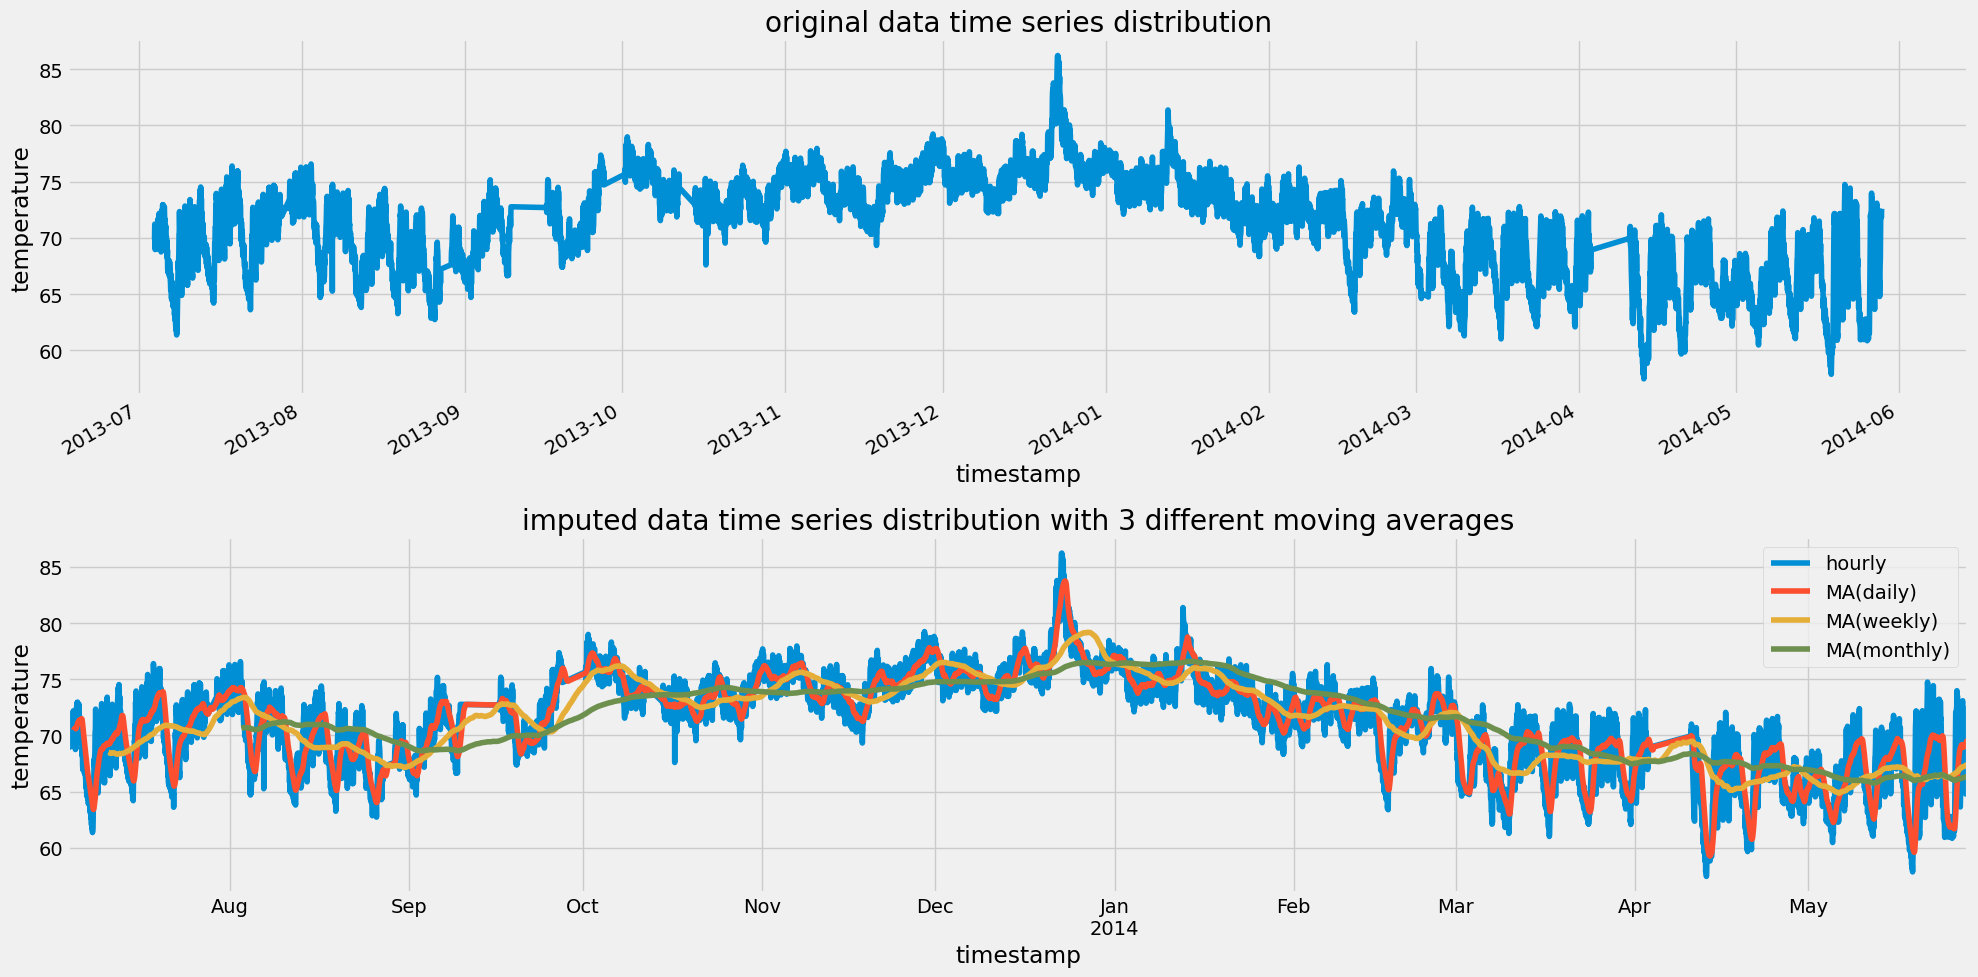

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight') # the fivethirtyeight style is popular in time series plotting

# plot the time series distribution
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
# uppler plot uses original dataframe only, so I can see the region with missing values
df['value'].plot(ax=ax[0])
ax[0].set_ylabel('temperature')
ax[0].set_title('original data time series distribution')


# bottom plot plot the imputed dataframe and the moving average
df_imputed['value'].plot(ax=ax[1], label='hourly')
df_imputed['MA_daily'].plot(ax=ax[1], label='MA(daily)')
df_imputed['MA_weekly'].plot(ax=ax[1], label='MA(weekly)')
df_imputed['MA_monthly'].plot(ax=ax[1], label='MA(monthly)')
ax[1].set_ylabel('temperature')
ax[1].set_title('imputed data time series distribution with 3 different moving averages')
ax[1].legend()

plt.tight_layout()
plt.show()

From the time series distribution, I notice the data has some patterns. 
1. **The small humps in each month:** 
- From the orange line, I can see the data has about 3 or 4 humps per month. 
- From the blue line, I can see some data are missing. Therefore, I see some straight lines, for example, there is a horizontal line between 2013-09 and 2013-10.
2. **The envelops:** 
- Since the data file name is called "ambient temperature system failer", the value column stands for temperature.
- Although the fluctuations are not huge, I notice the temperature increases from 2013-07 and reach the first peak about 2013-08, and the temperature slowly decreases until 2013-09. But the temperature increases again and reaches the 2nd peak about the end of 2013-12. Then the temperature gradually decreases til 2014-04 or 2014-05. Starting from 2014-05, it looks like the temperature starts to increase slightly. The increasing and decreasing trend can be seen from the envelops distributions (in green and red colors).

Now I want to see the distribution of monthly average.

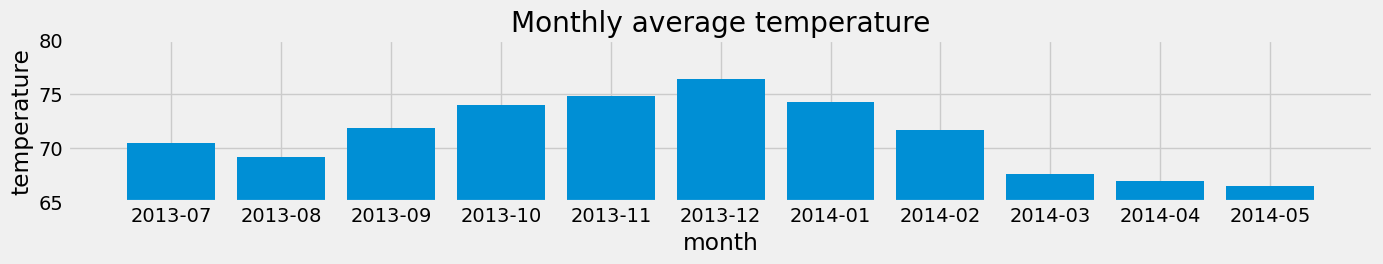

In [17]:
# resample by month and calculate the average
df_resample = df_imputed[['value']].resample('M').mean()
df_resample.head()

# Get YYYY-mm
x = [str(i.date())[:-3] for i in df_resample.index]

fig, ax = plt.subplots(figsize=(15, 2))
ax.bar(x, df_resample['value'])
ax.set_xlabel('month')
ax.set_ylabel('temperature')
ax.set_title('Monthly average temperature')
ax.set_ylim(65, 80)
plt.show()

From this monthly average, it is clear that the temperature slightly decreases between 2013-07 and 2013-08. And the temperature increases from 2013-08 and reach the peak on 2013-12. Starting from 2014-01, the temperature decreases again.

#### 2. histogram and density plots

Because the data values ranging from 57 to 86, I would like to see the data distribution using a histogram with bin size equals 1 degree.

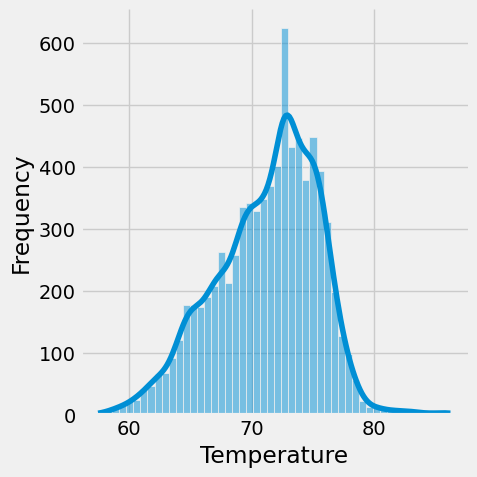

In [18]:
#
# histogram and density plots
#

# fig, ax = plt.subplots(figsize=(10, 3))
# df_imputed['value'].plot(kind='hist', bins=range(55, 90), ax=ax)
# ax.set_xlabel('Temperature')
# plt.show()

ax = sns.displot(df_imputed, x='value', kde=True)
ax.set(xlabel='Temperature', ylabel='Frequency')
plt.show()

The histogram shows that the data distribution looks like a left skewed gaussian distribution with peak about 73 degree. By setting `kde=True`, the kernel density, which is the same as probability density, is plotted.

#### 3. box plot:

Now I want to see the box plot which can show the 0.25, 0.5, 0.75 quantil in abox and some data points outside the $\pm 1.5$ IQR range. I also want to know how many data points are outside the $\pm 1.5$ IQR region, which I define them as outliers.

In [19]:
# Computing IQR
Q1 = df_imputed['value'].quantile(0.25)
Q3 = df_imputed['value'].quantile(0.75)
IQR = Q3 - Q1

# Select data points with value < Q1-1.5IQR or value > Q3+1.5IQR
df_outliers_lower = df_imputed[df_imputed['value']<(Q1-1.5*IQR)]
df_outliers_upper = df_imputed[df_imputed['value']>(Q3+1.5*IQR)]

df_outliers_lower.head()
df_outliers_upper.head()

# Number of outliers
print(f'Number of outliers = {len(df_outliers_lower) + len(df_outliers_upper)}')

Number of outliers = 52


In [20]:
len(df_outliers_lower)

35

In [21]:
len(df_outliers_upper)

17

In [22]:
df_imputed[['value']].describe()

,value
count,7888.000000
mean,71.254027
std,4.155257
min,57.458406
25%,68.544310
50%,71.934697
75%,74.337983
max,86.223213


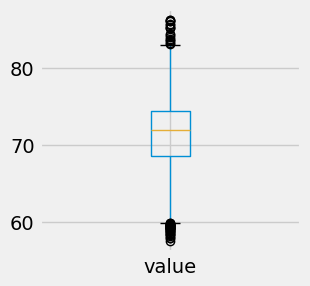

In [23]:
fig, ax = plt.subplots(figsize=(3, 3))
df_imputed[['value']].boxplot()
plt.show()

From the above box plot, we can see the 0.25, 0.5, 0.75 quantile in blue box and some outlier points in black dots.

Now I can also check the box plots in different time interval. Because the data ranges from 2013-07 to 2014-06, I think the best interval for the box plots is by month.

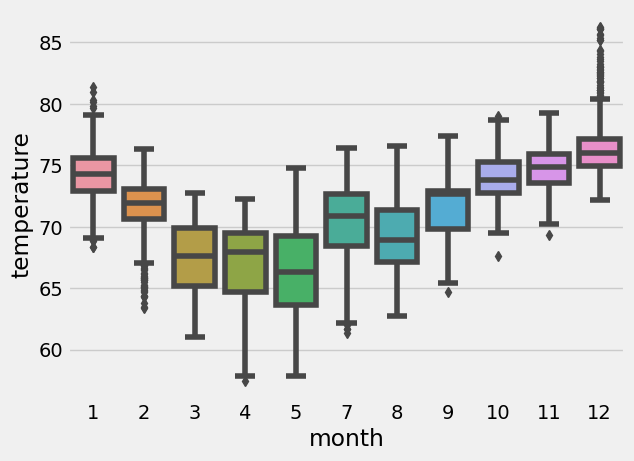

In [24]:
ax = sns.boxplot(data=df_imputed, x="month", y="value")
ax.set(ylabel='temperature')
plt.show()

The above plot shows an asymmetric "**V-shap**". This means the temperature is relative lower about April and May and relative higher at the January and December. The Feburary has many outliers below Q1-1.5IQR, and the January and December have many outliers above Q3+1.5IQR. This indicates these 3 months might have more anomaly.

#### 4. decomposition plot

Using the decomposition plot, I can check the trend, seasonality, and noise (residual) of the time series data.
* The trend can show the overall behavior of the data, for example, is the data increasing or decrease.
* The seasonality can show the repeated pattern in the data.
* The noise or residual can show how the data deviated from the expectations.

Because the ETS (Error, Trend, Seasonality) model has additive and multiplicative methods:
* additative: time series = $T(t) \bigoplus S(t) \bigoplus E(t)$
* multiplicative: time series = $T(t) \bigotimes S(t) \bigotimes E(t)$
I have tried these two methods with different period, and I find using multiplicative methods with period = 24 * 7
can provide best decompositive plots

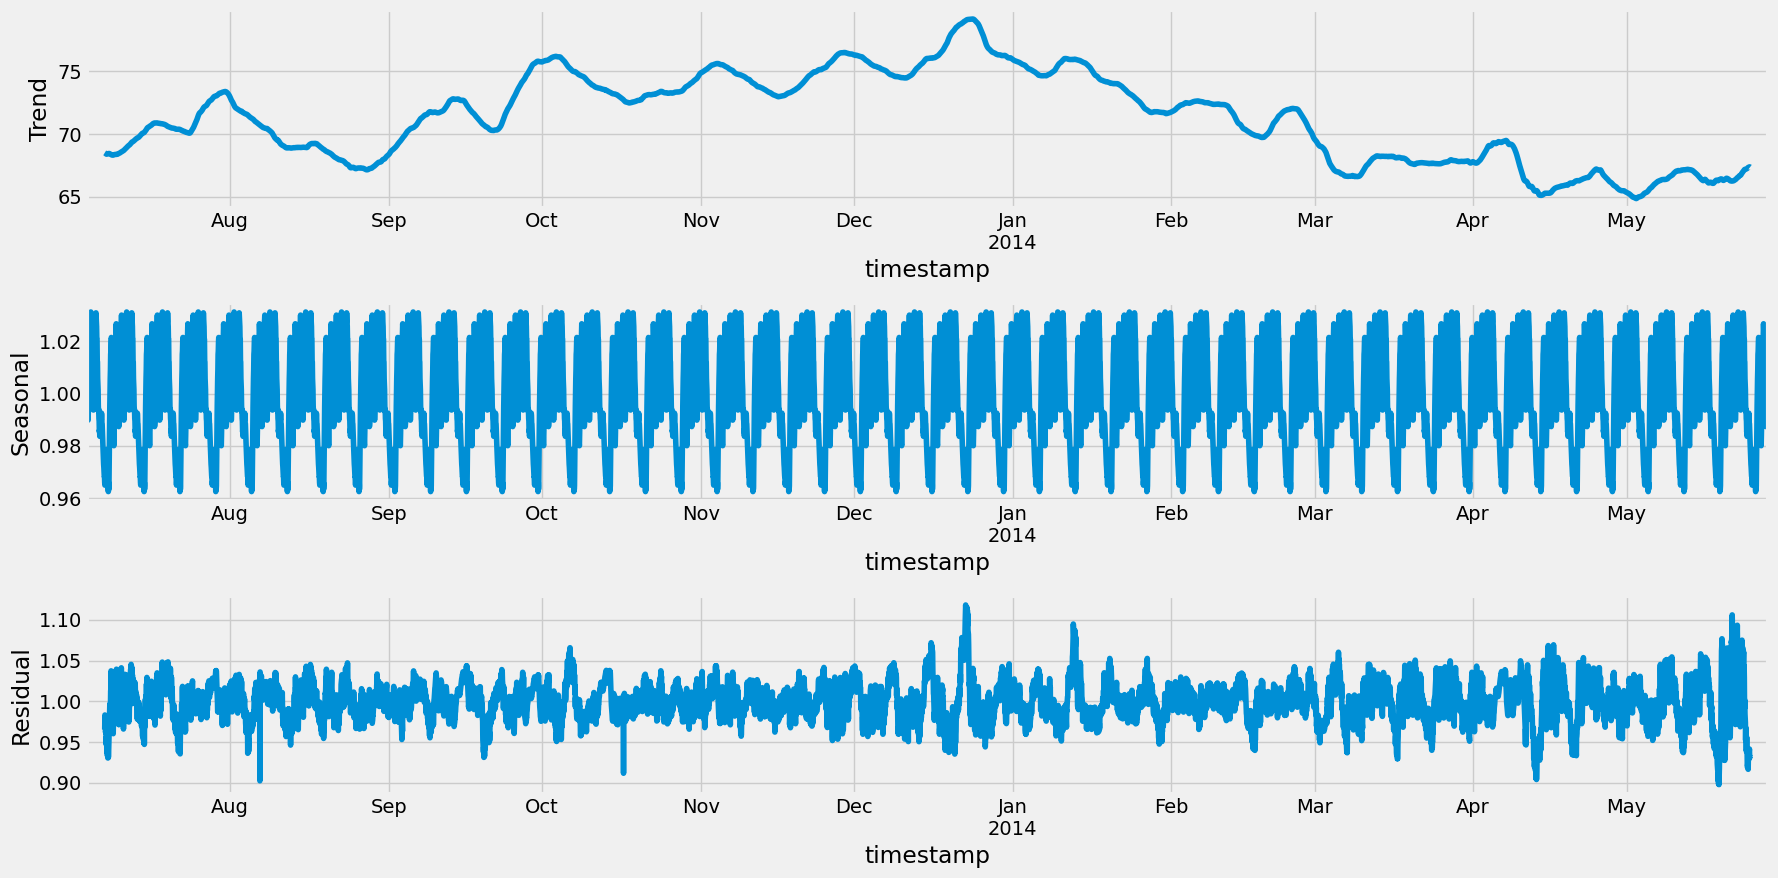

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_imputed['value'], model='multiplicative', period=24*7)
# fig = decomposition.plot() # this plot is too small and hard to read

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(3, 1, figsize=(18, 9))
trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')

seasonal.plot(ax=ax[1])
ax[1].set_ylabel('Seasonal')

residual.plot(ax=ax[2])
ax[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

Because I can see the clear repeated patterns in the seasonality, this could be very helpful to identify the anomaly. Also the residual plot shows most of the data point having residual between 0.95 and 1.05, the data points with residual **outside** (0.95, 1.05) region could be anormaly.

#### 5. lag scatter plot

In the time series, the lag simply means the previous data point. If we are at time=$t$ and the data is $y(t)$, then all the data we collected before time=$t$ are lag of $y(t)$. For example, lag=1 means $y(t-1)$, lag=2 means $y(t-2)$, ..., lag=N means $y(t-N)$.

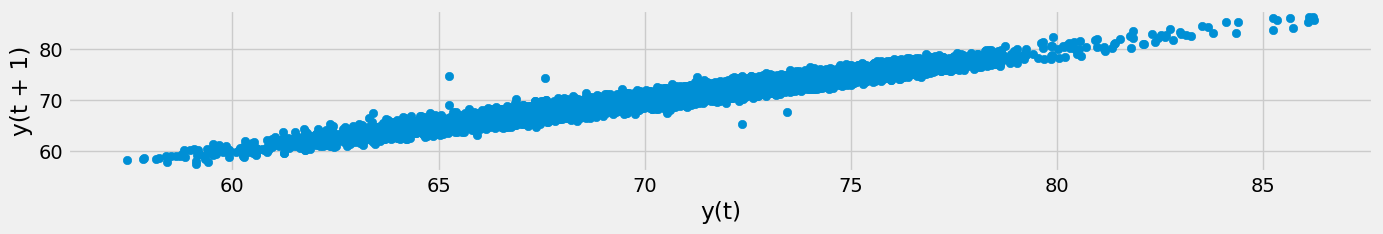

In [26]:
fig, ax = plt.subplots(figsize=(15, 2))
pd.plotting.lag_plot(df_imputed['value'], ax=ax)
plt.show()

From this lag plot, I see the strong correlation between $y(t)$ and $y(t-1)$. This could be helpful for identifying the anomaly.

#### 6. auto-correlation plot and partial auto-correlation plot

Because the lag plot shows there are strong positive correlation betweey $y(t)$ and $y(t-1)$. I can use the auto-correlation and partial auto-correlation plots to show their relationship.

* ACF is checking the relationship between $y_{i}(t)$ and $y_{j}(t-nlags)$ where $i \neq j$
* PACF is checking the relationship between $y_{i}(t)$ and $y_{i}(t-nlags)$

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


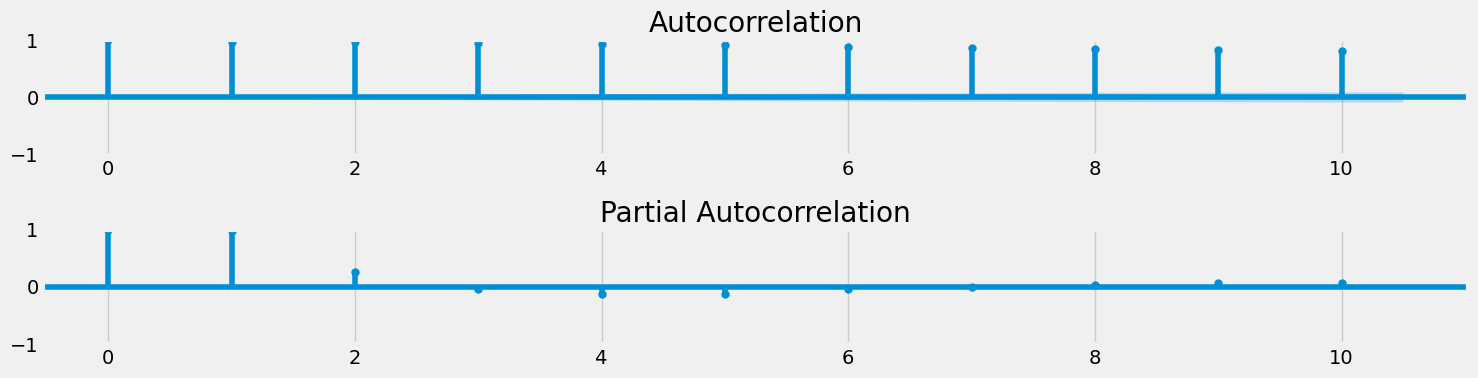

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15, 4))
plot_acf(df_imputed['value'], lags=10, ax=ax[0])
plot_pacf(df_imputed['value'], lags=10, ax=ax[1])
plt.tight_layout()
plt.show()

Because the data is univarate, the ACF plot is meanless, I can focus on the PACF plot. The PACF plot shows the strong positive correlation betweey $y(t)$ and $y(t-1)$ with correction value = 1. The lag=2, i.e. $y(t-2)$ also has slightly positive correlation with $y(t)$. Starting from lags $\geq 3$, the correlations are very small and can be neglected.

I wrap the visualization by showing 6 different plots and summary the observations
* The data ranges from 60 to 80. The data distribution is left skewed and most of data points has 73 degree.
* The temperature is relative lower in April and May, and relative higher in January and December
* Many outliers in January, February, and December.
* I see repeated pattern in seasonality with period=24*7, i.e. the pattern repeats weekly.
* Strong positive correlation between $y(t)$ and $y(t-1)$

All the above mentioned could be provided some clues for anormaly detection. 

## Step 3. Feature engineering

Because there are only timestamp and values in the time series data, the common method to do the time series data is decomposed the timestamp. The timestamp has the format "YYYY-mm-dd HH:MM:SS", I can decompose the timestamp into **year**, **month**, **day**, **hour**, **minute**, and **second**. I also can use the date information to know is the date a **weekday** or **weekend**, in which **week of a year**, in whic **quarter**, in the **morning**, **afternoon**, or **evening**?

In [28]:
df_imputed.head()

,value,year,month,day,hour,MA_daily,MA_weekly,MA_monthly
timestamp,,,,,,,,
2013-07-04 00:00:00,69.880835,2013,7,4,0,NaN,NaN,NaN
2013-07-04 01:00:00,71.220227,2013,7,4,1,NaN,NaN,NaN
2013-07-04 02:00:00,70.877805,2013,7,4,2,NaN,NaN,NaN
2013-07-04 03:00:00,68.959400,2013,7,4,3,NaN,NaN,NaN
2013-07-04 04:00:00,69.283551,2013,7,4,4,NaN,NaN,NaN


Because I created `MA_daily`, `MA_weekly`, and `MA_monthly` columns for visualization, I will drop them in the feature engineering part.

In [29]:
df_imputed.drop(columns=['MA_daily', 'MA_weekly', 'MA_monthly'], inplace=True)
df_imputed.head()

,value,year,month,day,hour
timestamp,,,,,
2013-07-04 00:00:00,69.880835,2013,7,4,0
2013-07-04 01:00:00,71.220227,2013,7,4,1
2013-07-04 02:00:00,70.877805,2013,7,4,2
2013-07-04 03:00:00,68.959400,2013,7,4,3
2013-07-04 04:00:00,69.283551,2013,7,4,4


Now, I am going to create the following new features
* week of year: week number in a year
* weekday: 0 for Mon, 1 for Tue, 2 for Wed, 3 for Thu, 4 for Fri, 5 for Sat, 6 for Sun
* weekend: 0 for Mon to Fri, 1 for Sat and Sun
* quarter:
* daytime: 0 for night, 1 for morning, 2 for afternoon, 3 for evening
* lag_1: value(y-1)
* temp_diff: value(y) - value(y-1)
* daily_avg
* weekly_avg
* monthly_avg
* daily_diff: value - daily_avg
* weekly_diff: value - weekly_avg
* monthly_diff: value - monthly_avg
* 0.25 quantile
* 0.5 quantile
* 0.75 quantile
* lower_bound: Q1-1.5IQR
* upper_bound: Q3+1.5IQR
* outlier: 0 for Q1-1.5IQR <= value <= Q3+1.5IQR, 1 for not outside the region

In [30]:
# get week of a year
df_imputed['weekofyear'] = df_imputed.index.isocalendar().week

# get weekday from timestamp, where Monday=0, Sunday=6.
df_imputed['weekday'] = df_imputed.index.weekday

# if the day is weekend (Saturday=5, Sunday=6), then set it to 1, otherwise set it to 0
df_imputed['weekend'] = df_imputed['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

# get the quarter
df_imputed['quarter'] = df_imputed.index.quarter

In [31]:
# Set daytime: night=0, morning=1, afternoon=2, evening=3
# where night = 0:00am to 6:00am, 
#       morning = 6:00am to 12:00pm
#       afternoon = 12:00pm to 18:00pm
#       evening = 18:00pm to 24:00pm
mapping_hour_to_daytime = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, # night
    6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, # morning
    12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, # afternoon
    18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3 # evening
}
df_imputed['daytime'] = df_imputed['hour'].map(mapping_hour_to_daytime)

* From the EDA, I know there is strong positive correlation between $y(t)$ and $y(t+1)$. Therefore, I want to create a new column called **lag_1**.
* And I can use the `lag_1` and `value` columns to calculate the temperature difference
* Because the data was taken hourly, I can calculate the daily, weekly, and monthly average and assign these values as new columns

In [32]:
# create a new column called lag_1
df_imputed['lag_1'] = df_imputed['value'].shift(1)

# create a new column temp_diff which is the temperature different between current row and previous row
df_imputed['temp_diff'] = df_imputed['value'] - df_imputed['lag_1']

In [33]:
# calculate daily average
df_daily_average = (
    df_imputed.groupby(['year', 'month', 'day'])
    .agg({'value': 'mean'})
    .rename(columns={'value': 'daily_avg'})
    .reset_index()
)
# display(df_daily_average.head())

# calculate weekly average
df_weekly_average = (
    df_imputed.groupby(['year', 'weekofyear'])
    .agg({'value': 'mean'})
    .rename(columns={'value': 'weekly_avg'})
    .reset_index()
)
# display(df_weekly_average.head())

# calculate monthly average
df_monthly_average = (
    df_imputed.groupby(['year', 'month'])
    .agg({'value': 'mean'})
    .rename(columns={'value': 'monthly_avg'})
    .reset_index()
)
# display(df_monthly_average.head())

In [34]:
# merge df_daily_average, df_weekly_average, and df_monthly_average into df_imputed
df_final = (
    df_imputed.merge(df_daily_average, on=['year', 'month', 'day'], how='left')
    .merge(df_weekly_average, on=['year', 'weekofyear'], how='left')
    .merge(df_monthly_average, on=['year', 'month'], how='left')
)
# df_final.head()

After adding `daily_avg`, `weekly_avg`, and `monthly_avg` columns into the dataframe, I can calculate the difference between value column and these 3 columns. The new columns are named `daily_diff`, `weekly_diff`, and `monthly_diff`.

In [35]:
df_final['daily_diff'] = df_final['value'] - df_final['daily_avg']
df_final['weekly_diff'] = df_final['value'] - df_final['weekly_avg']
df_final['monthly_diff'] = df_final['value'] - df_final['monthly_avg']
# df_final.head()

Because the boxplot shows there are outliers in each month and could be anomaly, I also want to include the Q1-1.5IQR, .25 quantile, .5 quantile, .75 quantile, Q3+1.5IQR from monthly results. Therefore, I can create a new columns call outliers. If the value < Q1-1.5IQR or value > Q3+1.5IQR, then the outlier =1, otherwise outlier = 0.

In [36]:
# calculate 0.25, 0.5, 0.75 quantile
df_quantile = (
    df_imputed[['year', 'month', 'value']]
    .groupby(['year', 'month'])
    .quantile([0.25, 0.5, 0.75])
    .reset_index()
    .rename(columns={'level_2':'quantile'})
)
# display(df_quantile.head())

# pivot the table
df_quantile = (
    pd.pivot_table(df_quantile, index=['year', 'month'], columns=['quantile'])
    .reset_index()
)
# rename columns
df_quantile.columns = ['year', 'month', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75']
# display(df_quantile.head())

# calculate Q1-1.5IQR and Q3+1.5IQR
df_quantile['lower_bound'] = (
    df_quantile['quantile_0.25']
    - 1.5 * ( df_quantile['quantile_0.75'] -  df_quantile['quantile_0.25'])
)
df_quantile['upper_bound'] = (
    df_quantile['quantile_0.25']
    + 1.5 * ( df_quantile['quantile_0.75'] -  df_quantile['quantile_0.25'])
)

display(df_quantile.head())

,year,month,quantile_0.25,quantile_0.5,quantile_0.75,lower_bound,upper_bound
0,2013,7,68.421405,70.902742,72.673599,62.043114,74.799696
1,2013,8,67.171028,68.927501,71.337771,60.920914,73.421142
2,2013,9,69.850021,72.697976,72.944834,65.207800,74.492241
3,2013,10,72.761170,73.845189,75.246697,69.032880,76.489461
4,2013,11,73.553215,74.865252,75.939900,69.973187,77.133243


In [37]:
df_final = (
    df_final.merge(df_quantile, on=['year', 'month'], how='left')
)
# display(df_final.head())

df_final['outlier'] = df_final.apply(
    lambda row: 1 if (row['value']<row['lower_bound']) or (row['value']>row['upper_bound']) else 0,
    axis=1
)
# display(df_final.head())

Because there are `NaN` in the first row, I would like to drop it.

In [38]:
df_final.dropna(axis=0, how='any', inplace=True)

Now the feature engineering is done. I created 23 extra columns. Here is the top 5 rows in the final dataframe

In [39]:
# set to display 100 columns
pd.set_option('display.max_columns', 100)

df_final.head()

,value,year,month,day,hour,weekofyear,weekday,weekend,quarter,daytime,lag_1,temp_diff,daily_avg,weekly_avg,monthly_avg,daily_diff,weekly_diff,monthly_diff,quantile_0.25,quantile_0.5,quantile_0.75,lower_bound,upper_bound,outlier
1,71.220227,2013,7,4,1,27,3,0,3,0,69.880835,1.339392,70.470846,68.812659,70.398647,0.749381,2.407568,0.821580,68.421405,70.902742,72.673599,62.043114,74.799696,0
2,70.877805,2013,7,4,2,27,3,0,3,0,71.220227,-0.342422,70.470846,68.812659,70.398647,0.406959,2.065146,0.479158,68.421405,70.902742,72.673599,62.043114,74.799696,0
3,68.959400,2013,7,4,3,27,3,0,3,0,70.877805,-1.918405,70.470846,68.812659,70.398647,-1.511446,0.146741,-1.439247,68.421405,70.902742,72.673599,62.043114,74.799696,0
4,69.283551,2013,7,4,4,27,3,0,3,0,68.959400,0.324151,70.470846,68.812659,70.398647,-1.187295,0.470892,-1.115096,68.421405,70.902742,72.673599,62.043114,74.799696,0
5,70.060966,2013,7,4,5,27,3,0,3,0,69.283551,0.777415,70.470846,68.812659,70.398647,-0.409880,1.248307,-0.337682,68.421405,70.902742,72.673599,62.043114,74.799696,0


In [40]:
df_final.columns

Index(['value', 'year', 'month', 'day', 'hour', 'weekofyear', 'weekday',
       'weekend', 'quarter', 'daytime', 'lag_1', 'temp_diff', 'daily_avg',
       'weekly_avg', 'monthly_avg', 'daily_diff', 'weekly_diff',
       'monthly_diff', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75',
       'lower_bound', 'upper_bound', 'outlier'],
      dtype='object')

## Step 4. Build model for anomaly detection

The question mentioned to pick either a statistical, clustering, or classification approach to detect anomaly. And the hint includes isolated Forest and One-Class SVM

Here are pros and cons for different methods:
* statistical:
  * The statistical method to detect anomaly is apply decomposition. The data can be decomposed into trend, seasonality, and noise (residual). By analyzing the deviation of residuals and introducing threshold for it, we will get anomaly data points.
  * **Pros**: It is simple and robust. Using statistical method to detect anomalies can apply to many different situations, and the anomalies are interpretable.
  * **Cons**: There are only a few options to tweak. For example, we can adjust the threshold. Besides this, there isn’t much you can do about it.


* Classification based model (Isolation Forest):
  * Isolation Forest is a kind of unsupervised learning. It utilizes the fact that the anomalies are data points which is minority and different from normal data. 
  * **Pros**: Like all other tree based methods, the isolation forest can use as many as features and doesn't require to scale or normalize the features.
  * **Cons**: Isolation forest also has the similar disadvantage as other tree-based models. If the features increasing a lot, the computational performance drops quickly.

* Clustering based model (One-Class SVM):
  * One-Class SVM is an unsupervised model for anomaly detection. This means the One-Class SVM doesn't have target label for model training. It learns the bounday from the nomal data points and identify the data outside the boundary as anomalies.
  * **Pros**: We can change the threshold to identify anomalies
  * **Cons**: The One-Class SVM requires more computional time.
  
  
#### For simplicity, I won't apply hyper-parameter tunning.

#### 1. statistical method

* I have applied seasonal decomposition in the step 1 for visualization section, therefore, I can use the **residual** directly. 
* Here, I define the anomalies are the data points which residual greater than $\pm 3\sigma$

In [41]:
x = residual.index
y = residual.values
# print(x)
# print(y)

# calculate the mean and std of y.
# Because there are a lot of nan in y, I have to use np.nanmean() and np.nanstd()
import numpy as np
mean_y = np.nanmean(y)
std_y = np.nanstd(y)
# print(mean_y, std_y)

# Defind outliers (anomalies) are data points which residual greater than +/-3 sigma.
outliers = residual[(residual.values>mean_y + 3*std_y)|(residual.values<mean_y - 3*std_y)]
# print(outliers)

In [42]:
df_temp1 = residual.to_frame()
df_temp2 = outliers.to_frame().rename(columns={'resid': 'outlier_resid'})
# display(df_temp1.head())
# display(df_temp2.head())

df_anomalies_residual = df_temp1.join(df_temp2)
# display(df_anomalies_residual.head())

In [43]:
df_anomalies = df_imputed[['value']].copy().join(df_temp2).fillna(value={'outlier_resid': 0})
# the current outlier column has the value of residual, I want to overwrite it with the temperature
df_anomalies['outlier'] = df_anomalies.apply(lambda row: row['value'] if row['outlier_resid'] > 0 else np.nan, axis=1)
# display(df_anomalies.head())

In [44]:
# total data points
print(f'Total data points = {len(df_anomalies)}')

# count how many rows which outlier is not None
print(f"Number of anomalies data = {df_anomalies['outlier'].count()}")

# percentage
ratio = round(df_anomalies['outlier'].count() / len(df_anomalies) * 100, 2)
print(f'There are about {ratio}% data are anomalies')

Total data points = 7888
Number of anomalies data = 64
There are about 0.81% data are anomalies


Using the statistical method, I define anomalies are data point greater than $\pm 3\sigma$ region and I find 64 anomalies data which corresponds to 0.81% of the dataset

The following plots shows the anomalies in residual plots and in the original time series

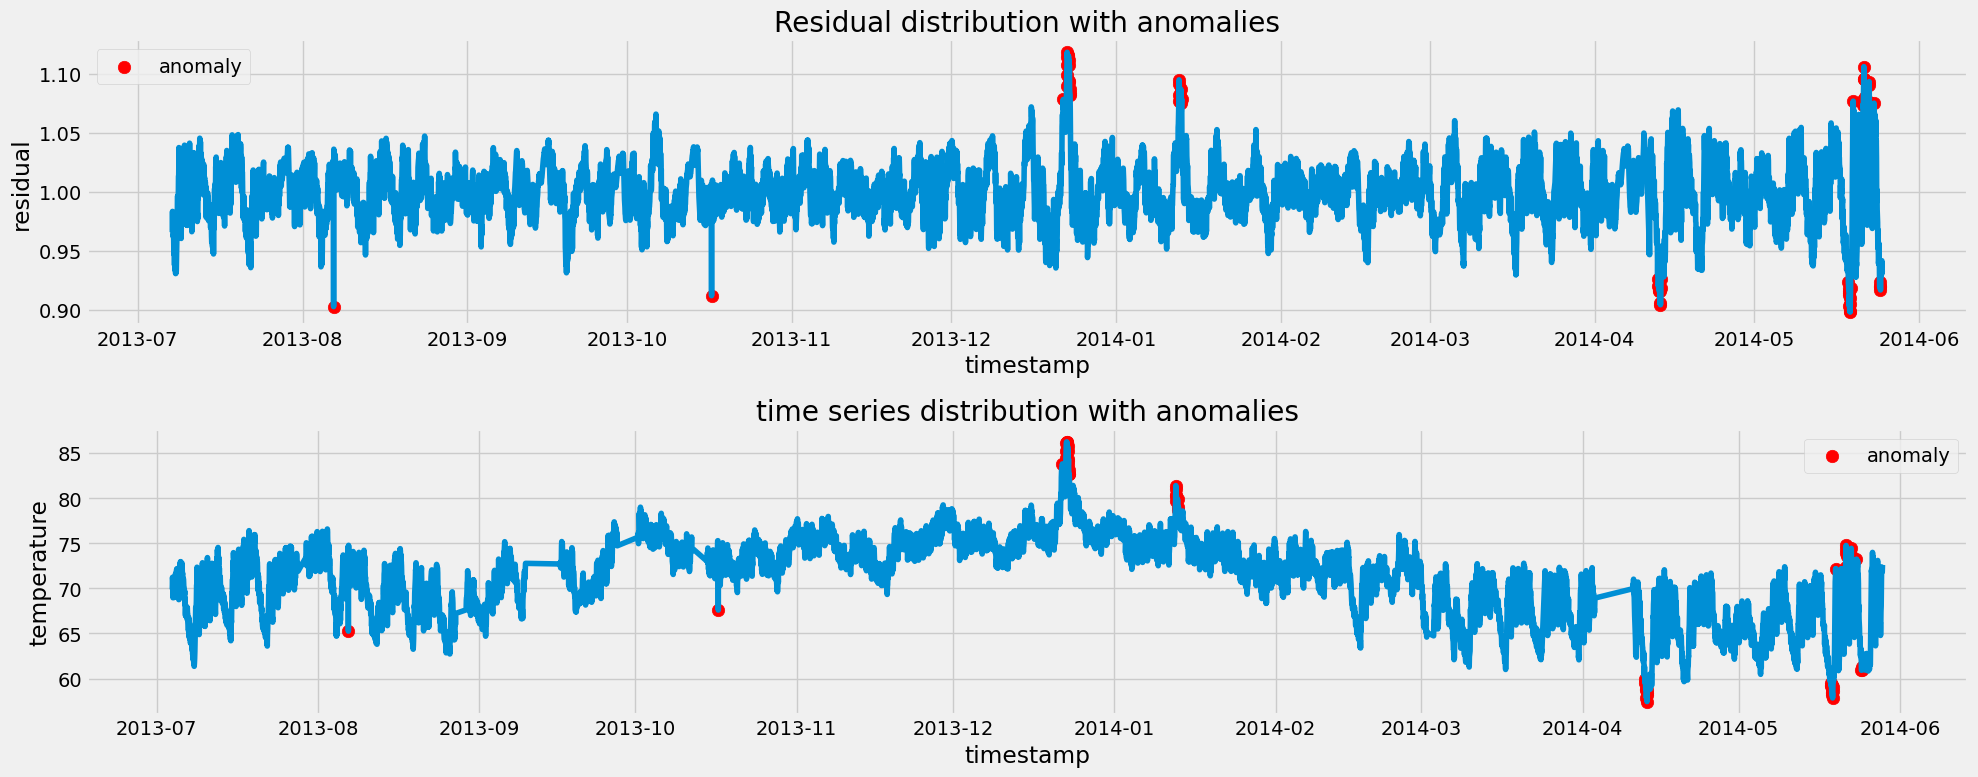

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20,8))
# plot the residual plot with anomalies in red
ax[0].plot(df_anomalies_residual.index, df_anomalies_residual['resid'])
ax[0].scatter(df_anomalies_residual.index, df_anomalies_residual['outlier_resid'], color='red', label='anomaly', s=80)
ax[0].set_xlabel('timestamp')
ax[0].set_ylabel('residual')
ax[0].set_title('Residual distribution with anomalies')
ax[0].legend()

# plot the temperature plot with anomalies in red
ax[1].plot(df_anomalies.index, df_anomalies['value'])
ax[1].scatter(df_anomalies.index, df_anomalies['outlier'], color='red', label='anomaly', s=80)
ax[1].set_xlabel('timestamp')
ax[1].set_ylabel('temperature')
ax[1].set_title('time series distribution with anomalies')
ax[1].legend()

plt.tight_layout()
plt.show()

#### 2. Isolation Forest

For simplicity, I use the default 100 trees (i.e., `n_estimators=100`) with outlier fraction 1% (i.e. `contaminatioin=0.01`) and only use 1 feature to trean each tree (`max_features=1.0`). All samples are used in the training (`max_samples=auto`)

In [46]:
from sklearn.ensemble import IsolationForest

# Because I want to use all data to build model, I won't separate the data into train and test sets

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), max_features=1.0)
model.fit(df_final)
df_final['anomaly_iso']=model.predict(df_final)
# display(df_final.head())

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [47]:
# After prediction, I only need value and anomaly_iso columns for making plot
df_anomaly_iso = df_final[['value', 'anomaly_iso']].copy()

# Assign the timestamp as index
# Because I drop first row (timestamp=2013-07-04 00:00:00) from the dataset when I do feature engineering,
# I have to use the timestamp index starting from 1
df_anomaly_iso.index = df_imputed.index[1:]

# If anomaly_is=-1, then this stands for anomaly. 
# I create a new column anomaly_value which save the value if this row is an anomaly.
df_anomaly_iso['anomaly_value'] = df_anomaly_iso.apply(
    lambda row: row['value'] if row['anomaly_iso']==-1 else np.nan,
    axis=1
)

# df_anomaly_iso.head()

In [48]:
# total data points
print(f'Total data points = {len(df_anomaly_iso)}')

# count how many rows which outlier is not None
print(f"Number of anomalies data = {df_anomaly_iso['anomaly_value'].count()}")

# percentage
ratio = round(df_anomaly_iso['anomaly_value'].count() / len(df_anomaly_iso) * 100, 2)
print(f'There are about {ratio}% data are anomalies')

Total data points = 7887
Number of anomalies data = 79
There are about 1.0% data are anomalies


Since I set contanimation=1%, the isolation forest model identify 79 anomalies which corresponds to 1% of the original data. The following plot shows the anomalies w.r.t original data.

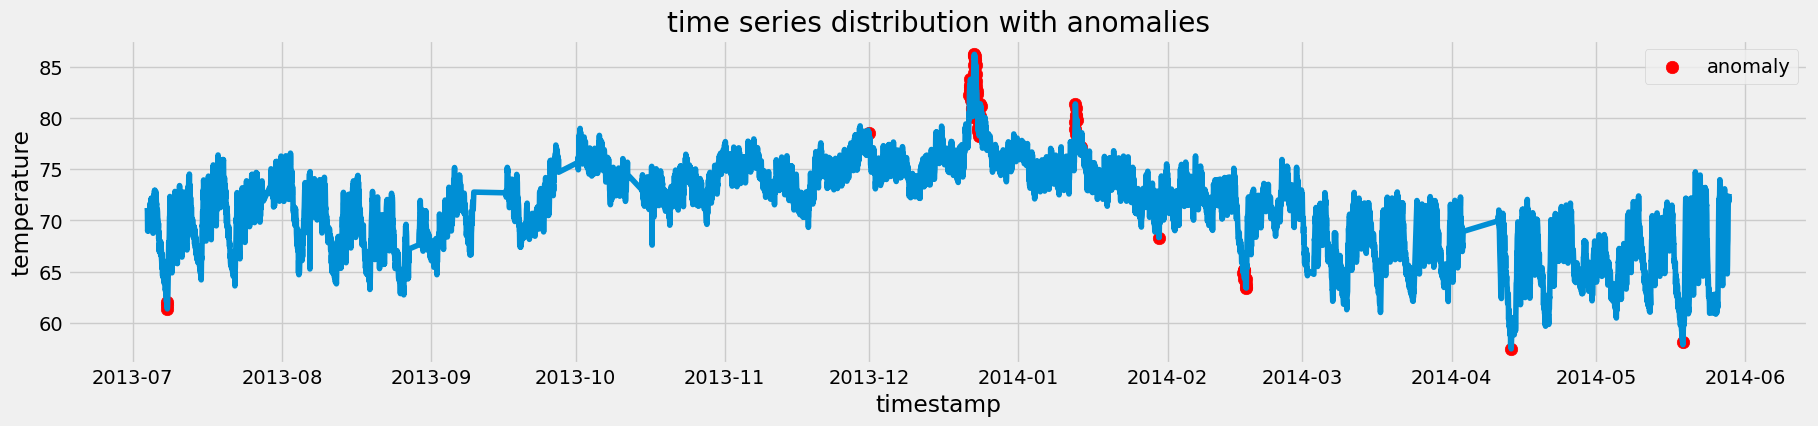

In [49]:
fig, ax = plt.subplots(figsize=(20,4))
# plot the temperature plot with anomalies in red
ax.plot(df_anomaly_iso.index, df_anomaly_iso['value'])
ax.scatter(df_anomaly_iso.index, df_anomaly_iso['anomaly_value'], color='red', label='anomaly', s=80)
ax.set_xlabel('timestamp')
ax.set_ylabel('temperature')
ax.set_title('time series distribution with anomalies')
ax.legend()
plt.show()

#### 3. One-Class SVM

* Because I added `anomaly_iso` column in previous section when we use isolation forest model, I have to drop this column before I pass the data into one-class svm model.
* Specify the percentage = 1% (`nu=0.01`), use the radial basis function as kernel, and set the kernal coefficient equals 1 (`gamma=auto`)

In [50]:
# select all columns except anomaly_iso
cols = df_final.columns.difference(['anomaly_iso'])

from sklearn.svm import OneClassSVM
svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
svm.fit(df_final[cols])
df_final['anomaly_svm'] = svm.predict(df_final[cols])

In [51]:
# After prediction, I am interested in value and anomaly_svm columns
df_anomaly_svm = df_final[['value', 'anomaly_svm']].copy()

# set the index as timestamp
df_anomaly_svm.index = df_imputed.index[1:]

# If anomaly_is=-1, then this stands for anomaly. 
df_anomaly_svm['anomaly_value'] = df_anomaly_svm.apply(
    lambda row: row['value'] if row['anomaly_svm']==-1 else np.nan,
    axis=1
)

# df_anomaly_svm.head()

In [52]:
# total data points
print(f'Total data points = {len(df_anomaly_svm)}')

# count how many rows which outlier is not None
print(f"Number of anomalies data = {df_anomaly_svm['anomaly_value'].count()}")

# percentage
ratio = round(df_anomaly_svm['anomaly_value'].count() / len(df_anomaly_svm) * 100, 2)
print(f'There are about {ratio}% data are anomalies')

Total data points = 7887
Number of anomalies data = 1216
There are about 15.42% data are anomalies


Although I set anomalies percentage to 1% (nu=0.01), the One-Class SVM find 1216 anomalies which correspond to 15.42% of the data. The following plot demonstrates the anomalies w.r.t original data

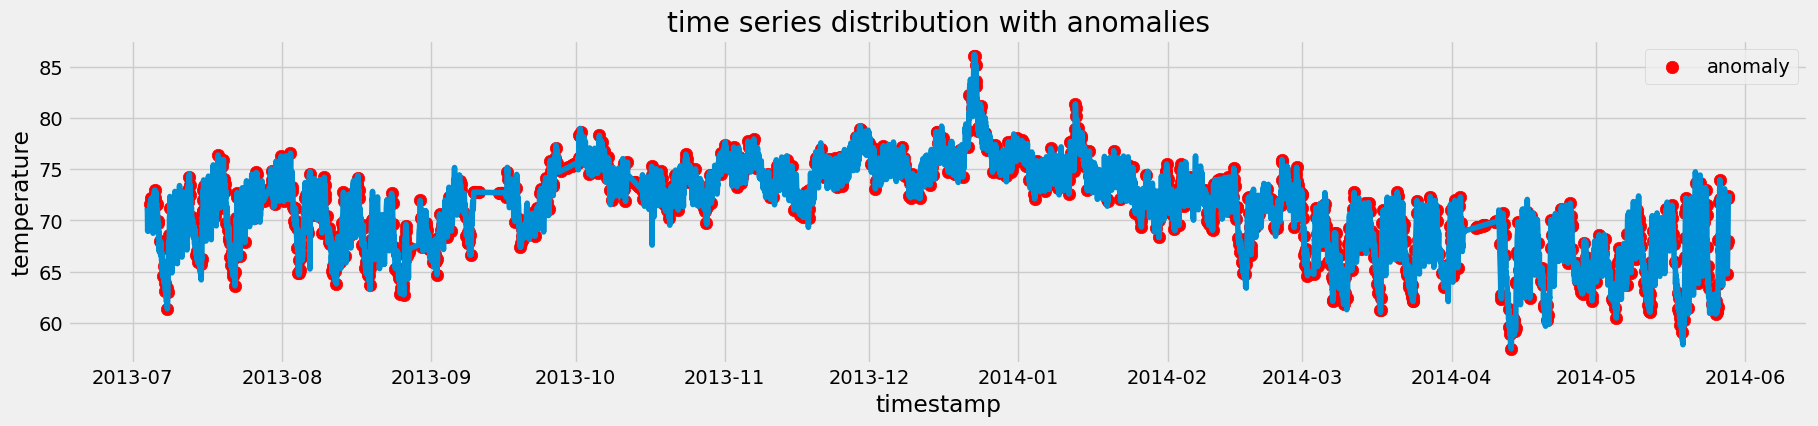

In [53]:
fig, ax = plt.subplots(figsize=(20,4))
# plot the temperature plot with anomalies in red
ax.plot(df_anomaly_svm.index, df_anomaly_svm['value'])
ax.scatter(df_anomaly_svm.index, df_anomaly_svm['anomaly_value'], color='red', label='anomaly', s=80)
ax.set_xlabel('timestamp')
ax.set_ylabel('temperature')
ax.set_title('time series distribution with anomalies')
ax.legend()
plt.show()

## Step 5. Summary

* The data has strong positive auto-correlation between current record and previous record (lag=1)
* The data has seasonal pattern
* The data distribution is left-skewed and peak at 73 degree
* The data is lower in April and May. The data is higher in December and January
* The statistical method shows 64 anomalies, the Isolation Forest model catche 79 anomalies ($\sim$1% of the data). But the One-Class SVM identifies 1216 anomalies ($\sim$15.42%) of the data.
  * For my personal point of view, the results from statistical and Isolation Forest model are more reliable.